# Main Focus of the Notebook: Exploratory Data Analysis and Dropping detected spots which are most likely noise

Note: 
For this notebook please read all the markdowns before each cell as this is an iterative notebook and its desirable to read instructions before running that cell for the first time you are running it. 

In [9]:
from os import path
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
import napari
from skimage import io
import matplotlib.pyplot as plt
import seaborn as sns
import sys 
import zarr
import dask.array as da
import os 
sys.path.append('../src/')

from detections_preprocessing import hist_plot, box_whisker_plot

plt.rcParams["font.family"] = ""

### Do not change the code in the cell below 

In [10]:
# This assumes that your notebook is inside 'Jupyter Notebooks', which is at the same level as 'test_data'
base_dir = os.path.join(os.path.dirname(os.path.abspath("__file__")), '..', 'movie_data')
# base_dir = os.path.join(os.path.dirname(os.path.abspath("__file__")), '..', 'test_movie_1')

zarr_directory = 'zarr_file/all_channels_data'
zarr_full_path = os.path.join(base_dir, zarr_directory)

input_directory = 'datasets'
input_file_name = 'all_detections_channel3.pkl'
input_directory_full = os.path.join(base_dir,input_directory, input_file_name)

output_directory = 'datasets'
output_file_name = 'cleaned_spots_intensities_c3_all.pkl'
output_directory_full = os.path.join(base_dir,output_directory, output_file_name)

In [11]:
spots_df = pd.read_pickle(input_directory_full)

z2 = zarr.open(zarr_full_path, mode='r')
z2.shape

(130, 3, 112, 2052, 340)

In [12]:
def calculate_whiskers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = Q1 - 1.5 * IQR
    upper_whisker = Q3 + 1.5 * IQR
    return lower_whisker, upper_whisker

# calculate the mean error (distance) of spot center and size, avg for xyz
spots_df['mean_errors_mu'] = spots_df['errors'].apply(lambda x: pd.Series(x[1]).mean())
spots_df['mean_errors_sigma'] = spots_df['errors'].apply(lambda x: pd.Series(x[2]).mean())

# Assuming spots_df is your DataFrame
columns = ['amplitude', 'sigma_x', 'sigma_y', 'sigma_z', 'mean_errors_mu','mean_errors_sigma']
whiskers = {}

for col in columns:
    lower_whisker, upper_whisker = calculate_whiskers(spots_df[col])
    whiskers[col] = {'lower_whisker': lower_whisker, 'upper_whisker': upper_whisker}

amplitude_upper_limit = whiskers['amplitude']['upper_whisker']
sigmax_upper_limit = whiskers['sigma_x']['upper_whisker']
sigmay_upper_limit = whiskers['sigma_y']['upper_whisker']
sigmaz_upper_limit = whiskers['sigma_z']['upper_whisker']

# by default the lower limit for detection size is 0
sigmax_lower_limit = 0
sigmay_lower_limit = 0
sigmaz_lower_limit = 0

# uncomment the following three lines if you want to filter the detections with low detection size

# sigmax_lower_limit = whiskers['sigma_x']['lower_whisker']
# sigmay_lower_limit = whiskers['sigma_y']['lower_whisker']
# sigmaz_lower_limit = whiskers['sigma_z']['lower_whisker']

mean_errors_mu_upper_limit = whiskers['mean_errors_mu']['upper_whisker']
mean_errors_sigma_upper_limit = whiskers['mean_errors_sigma']['upper_whisker']

## Adjust these tolerance parameters to adjust how strict the detection filtering is 
Below 1 = more strict; details below

In [13]:
############################################
# remove bright detections
amplitude_tolerance = 5

# remove large detections
sigmax_tolerance = 5.0
sigmay_tolerance = 5.0
sigmaz_tolerance = 4.0 

# remove low detection quality detections
quality_threshold_mu = 3.0
quality_threshold_sigma = 3.0
############################################

print(f'the upper limit for amplitude is {round(amplitude_upper_limit*amplitude_tolerance,2)}')
print(f'the upper limit for sigma x  is {round(sigmax_upper_limit*sigmax_tolerance,2)}')
print(f'the upper limit for sigma y is {round(sigmay_upper_limit*sigmay_tolerance,2)}')
print(f'the upper limit for sigma z is {round(sigmaz_upper_limit*sigmaz_tolerance,2)}')
print(f'the upper limit for mean error mu is {round(mean_errors_mu_upper_limit*quality_threshold_mu,2)}')
print(f'the upper limit for mean error sigma is {round(mean_errors_sigma_upper_limit*quality_threshold_sigma,2)}')

the upper limit for amplitude is 1472.65
the upper limit for sigma x  is 10.0
the upper limit for sigma y is 17.5
the upper limit for sigma z is 22.0
the upper limit for mean error mu is 4.27
the upper limit for mean error sigma is 6.49


In [14]:
# Condition setting

# don't change anything in this cell
#dropping spots above certain threshold 
condition_1 = spots_df['amplitude'] <= amplitude_upper_limit * amplitude_tolerance 

#dropping spots above certain standard dev in x
condition_2 = spots_df['sigma_x'] <= sigmax_upper_limit * sigmax_tolerance


#dropping spots above certain standard dev in y 
condition_3 = spots_df['sigma_y'] <= sigmay_upper_limit * sigmay_tolerance


#dropping spots above certain standard dev in z
condition_4 = spots_df['sigma_z'] <= sigmaz_upper_limit * sigmaz_tolerance


## No need to change the below conditions 

#dropping spots below certain standard dev in x
condition_5 = spots_df['sigma_x'] >= sigmax_lower_limit

#dropping spots below certain standard dev in y
condition_6 = spots_df['sigma_y'] >= sigmay_lower_limit

#dropping spots below certain standard dev in z
condition_7 = spots_df['sigma_z'] >= sigmaz_lower_limit

#dropping spots out of bounds of z axis 
condition_8 = spots_df['mu_z'] >= 0
condition_9 = spots_df['mu_z'] <= z2.shape[2]

#dropping spots out of bounds of x axis 
condition_10 = spots_df['mu_x'] >= 0
condition_11 = spots_df['mu_x'] <= z2.shape[4]

#dropping spots out of bounds of y axis 
condition_12 = spots_df['mu_y'] >= 0
condition_13 = spots_df['mu_y'] <= z2.shape[3]

condition_14 = spots_df['mean_errors_mu'] <= mean_errors_mu_upper_limit * quality_threshold_mu
condition_15 = spots_df['mean_errors_sigma'] <= mean_errors_sigma_upper_limit * quality_threshold_sigma

# Combine the conditions using logical AND (&)
cleaned_spots_df = spots_df[condition_1 & condition_2 & condition_3 & condition_4 & condition_5 & condition_6 &
condition_7 & condition_8 & condition_9 & condition_10 & condition_11 & condition_11 & condition_12 & condition_13 & condition_14 & condition_15].reset_index(drop = True)

dropped_spots = spots_df[~(condition_1 & condition_2 & condition_3 & condition_4 & condition_5 & condition_6 &
condition_7 & condition_8 & condition_9 & condition_10 & condition_11 & condition_11 & condition_12 & condition_13 & condition_14 & condition_15)]


In [ ]:
# Save the DataFrame to a Pickle file
cleaned_spots_df.to_pickle(output_directory_full)

## VISUALISATION

Use this viewer to visually assess whether the detections correspond to the spots you see, and if the dropped detections correspond to noise.

Adjust the thresholds accordingly based on guidelines below.
In this notebook you can only drop points not add points, so if you think spots have been missed during detection, go back to notebook 01. 

In [15]:
# Create a napari viewer
viewer = napari.Viewer()

#access channel 3 only from zarr array 
dask_array = da.from_zarr(z2)

#the axis arrangement is (t,c,z,y,x)
#for the sake of improved performance only 1 channel could be imported here (if images get super large and performance issues occur)
all_channels = dask_array[:,:,:,:,:]

# Add the 4D stack to the viewer
# layer_raw = viewer.add_image(all_channels, channel_axis = 1, name = ['Channel 1', 'Channel 2', 'Channel 3'])
layer_raw = viewer.add_image(all_channels, channel_axis = 1, name = ['channel 1', 'channel 2', 'channel 3'], interpolation3d = 'nearest', blending = 'additive', colormap = 'gray_r', visible = [False, False, True])

#other useful parameters 
#color_map = list
#contrast_limits = list of list 

# Add Bounding Box
layer_raw[0].bounding_box.visible = True
layer_raw[1].bounding_box.visible = True
layer_raw[2].bounding_box.visible = True

#Visualising all dropped spots and the cleaned spots 
points_layer = viewer.add_points(cleaned_spots_df[["frame", "mu_z", "mu_y", "mu_x"]], size=3, 
                                name = 'Cleaned Spots', face_color = 'lime', symbol = 'ring')


points_layer = viewer.add_points(spots_df[~condition_1][["frame", "mu_z", "mu_y", "mu_x"]], size=3, 
                                name = 'High amplitude', face_color = '#aa0000', symbol = 'ring')

points_layer = viewer.add_points(spots_df[~condition_2][["frame", "mu_z", "mu_y", "mu_x"]], size=3,
                                name = 'High sigma x', face_color = '#ff0000', symbol = 'ring')

points_layer = viewer.add_points(spots_df[~condition_3][["frame", "mu_z", "mu_y", "mu_x"]], size=3,
                                name = 'High sigma y', face_color = '#ff0000', symbol = 'ring')

points_layer = viewer.add_points(spots_df[~condition_4][["frame", "mu_z", "mu_y", "mu_x"]], size=3,
                                name = 'High sigma z', face_color = '#ff0000', symbol = 'ring')

points_layer = viewer.add_points(spots_df[~condition_5][["frame", "mu_z", "mu_y", "mu_x"]], size=3,
                                name = 'Low sigma x', face_color = '#ff00ff', symbol = 'ring')

points_layer = viewer.add_points(spots_df[~condition_6][["frame", "mu_z", "mu_y", "mu_x"]], size=3,
                                name = 'Low sigma y', face_color = '#ff00ff', symbol = 'ring')

points_layer = viewer.add_points(spots_df[~condition_7][["frame", "mu_z", "mu_y", "mu_x"]], size=3,
                                name = 'Low sigma z', face_color = '#ff00ff', symbol = 'ring')

points_layer = viewer.add_points(spots_df[~condition_8&condition_9&condition_10&condition_12&condition_13][["frame", "mu_z", "mu_y", "mu_x"]], size=3,
                                name = 'Out of bounds', face_color = '#aa007f', symbol = 'ring')

points_layer = viewer.add_points(spots_df[~condition_14][["frame", "mu_z", "mu_y", "mu_x"]], size=3,
                                name = 'High mean error mu', face_color = '#ff557f', symbol = 'ring')

points_layer = viewer.add_points(spots_df[~condition_15][["frame", "mu_z", "mu_y", "mu_x"]], size=3,
                                name = 'High mean error sigma', face_color = '#ff557f', symbol = 'ring')

# points_layer = viewer.add_points(dropped_spots[["frame", "mu_z", "mu_y", "mu_x"]], size=3, 
#                                 name = 'Dropped Spots', face_color = 'blue', symbol = 'ring')

# points_layer = viewer.add_points(spots_df[["frame", "mu_z", "mu_y", "mu_x"]], size=3, 
#                                 name = 'All Spots', face_color = 'white', symbol = 'ring')

/Users/makamats/opt/anaconda3/envs/cme_pipeline/lib/python3.10/site-packages/napari/_vispy/layers/image.py:251: UserWarning: data shape (112, 2052, 340) exceeds GL_MAX_TEXTURE_SIZE 2048 in at least one axis and will be downsampled. Rendering is currently in 3D mode.
  warnings.warn(
/Users/makamats/opt/anaconda3/envs/cme_pipeline/lib/python3.10/site-packages/napari/_vispy/layers/image.py:251: UserWarning: data shape (112, 2052, 340) exceeds GL_MAX_TEXTURE_SIZE 2048 in at least one axis and will be downsampled. Rendering is currently in 3D mode.
  warnings.warn(
/Users/makamats/opt/anaconda3/envs/cme_pipeline/lib/python3.10/site-packages/napari/_vispy/layers/image.py:251: UserWarning: data shape (112, 2052, 340) exceeds GL_MAX_TEXTURE_SIZE 2048 in at least one axis and will be downsampled. Rendering is currently in 3D mode.
  warnings.warn(
/Users/makamats/opt/anaconda3/envs/cme_pipeline/lib/python3.10/site-packages/napari/_vispy/layers/image.py:251: UserWarning: data shape (112, 2052, 

## The goal is for the green spots to circle true spots, and the red-ish spots to circle noise

* Toggle each red circle one at a time and assess if it captures noise. If it is capturing real spots, then increase the tolerance for that feature and re run the condition setting and visualization cells.

* Look at the green circles. If the green circles are capturing noise, then increase the tolerance for a feature and see if it changes. 

* You can also use the histograms below to guide your choice: look for breaks between two distributions, or long tails

* Repeat until you're satisfied with the quality of your detections!


## The red dotted line shows the value where cutoff has been set. This means that all values above the cutoff have been dropped 

22.0


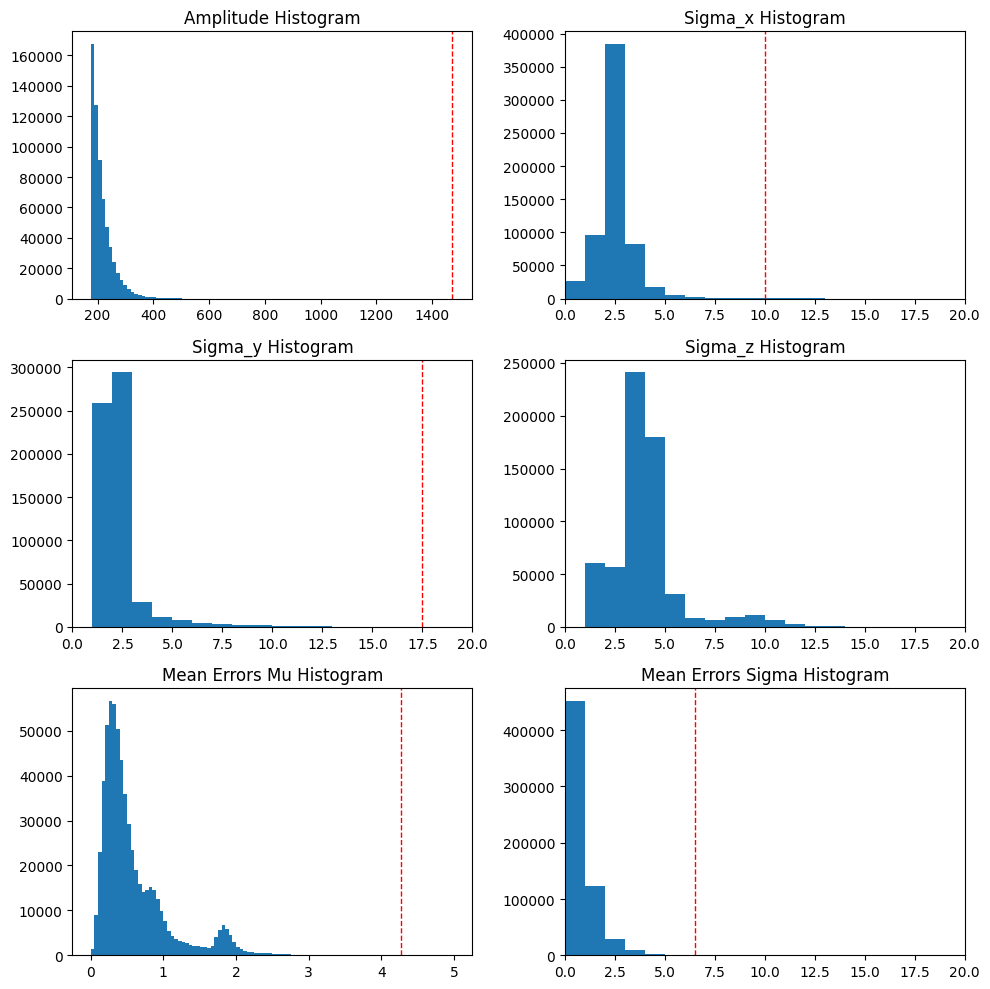

In [16]:

amplitude_cutoff = amplitude_upper_limit * amplitude_tolerance 
sigmax_cutoff = sigmax_upper_limit * sigmax_tolerance
sigmay_cutoff = sigmay_upper_limit * sigmay_tolerance
sigmaz_cutoff = sigmaz_upper_limit * sigmaz_tolerance
mu_upper_cutoff = mean_errors_mu_upper_limit * quality_threshold_mu
sigma_upper_cutoff = mean_errors_sigma_upper_limit * quality_threshold_sigma

print(sigmaz_cutoff)

# Assuming cleaned_spots_df is your DataFrame with columns 'Amplitude', 'sigma_x', 'sigma_y', 'sigma_z'

# Set up subplots as a 2x2 grid
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Histogram for Amplitude with bins of size 50 starting from 180
axes[0].hist(spots_df['amplitude'].dropna(), bins=100)
axes[0].axvline(amplitude_cutoff, color='r', linestyle='dashed', linewidth=1)
axes[0].set_title('Amplitude Histogram')

# Histogram for sigma_x with bins of size 1 starting from 0
axes[1].hist(spots_df['sigma_x'].dropna(), bins=range(0, int(spots_df['sigma_x'].max()) + 1, 1))
axes[1].axvline(sigmax_cutoff, color='r', linestyle='dashed', linewidth=1)
axes[1].set_xlim(0, 20)
axes[1].set_title('Sigma_x Histogram')

# Histogram for sigma_y with bins of size 1 starting from 0
axes[2].hist(spots_df['sigma_y'].dropna(), bins=range(0, int(spots_df['sigma_y'].max()) + 1, 1))
axes[2].axvline(sigmay_cutoff, color='r', linestyle='dashed', linewidth=1)
axes[2].set_xlim(0, 20)
axes[2].set_title('Sigma_y Histogram')

# Histogram for sigma_z with bins of size 1 starting from 0
axes[3].hist(spots_df['sigma_z'].dropna(), bins=range(0, int(spots_df['sigma_z'].max()) + 1, 1))
axes[3].axvline(sigmaz_cutoff, color='r', linestyle='dashed', linewidth=1)
axes[3].set_xlim(0, 20)
axes[3].set_title('Sigma_z Histogram')

# Histogram for mean_errors_mu with bins of size 0.01 starting from 0
axes[4].hist(spots_df['mean_errors_mu'].dropna(), 100)
axes[4].axvline(mu_upper_cutoff, color='r', linestyle='dashed', linewidth=1)
axes[4].set_title('Mean Errors Mu Histogram')

# Histogram for mean_errors_sigma with bins of size 0.01 starting from 0
axes[5].hist(spots_df['mean_errors_sigma'].dropna(), bins=range(0, int(spots_df['mean_errors_sigma'].max()) + 1, 1))
axes[5].axvline(sigma_upper_cutoff, color='r', linestyle='dashed', linewidth=1)
axes[5].set_xlim(0, 20)
axes[5].set_title('Mean Errors Sigma Histogram')


# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()
